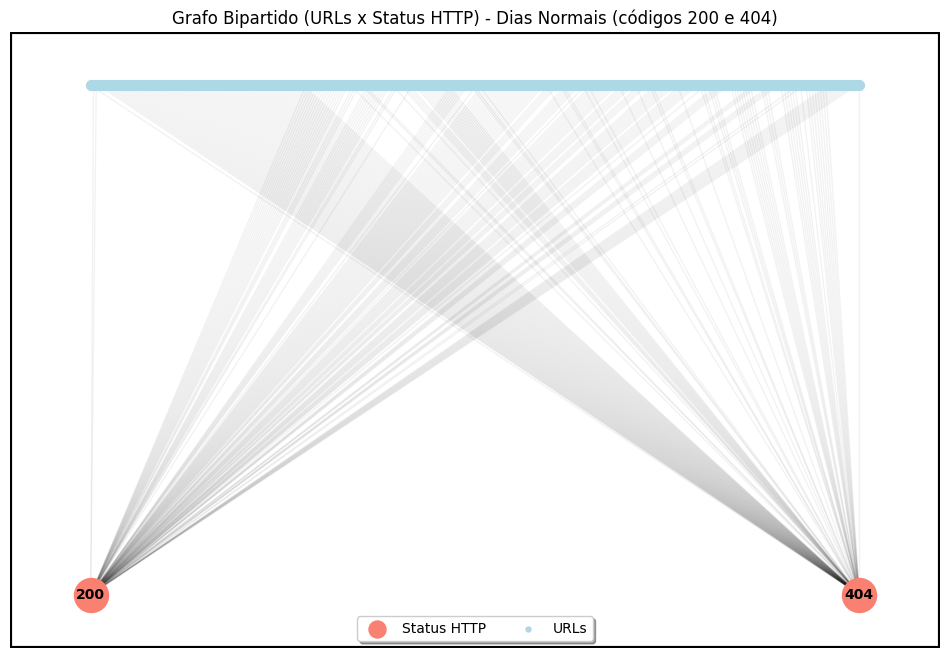

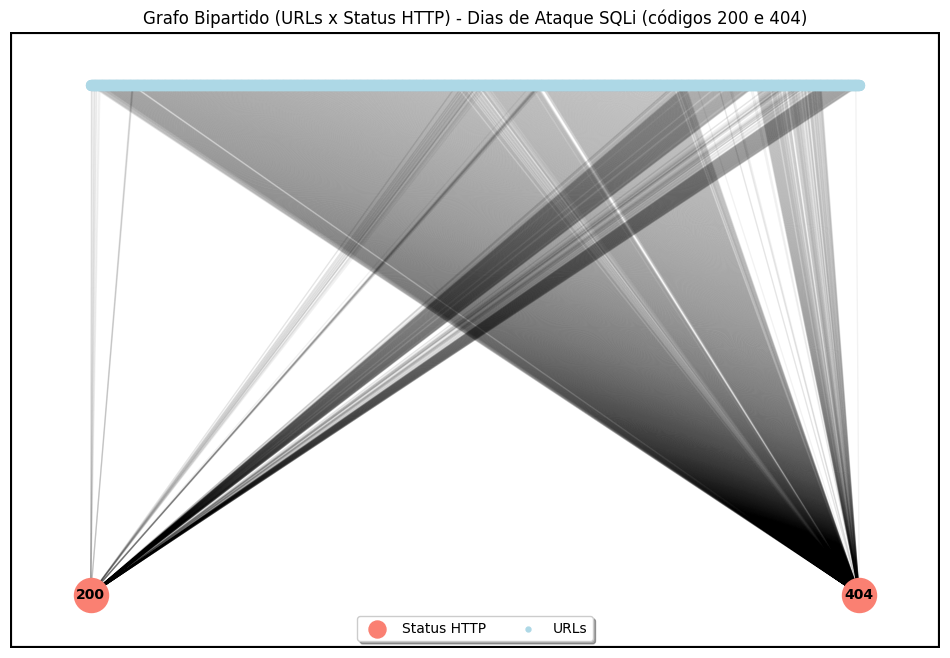

In [1]:
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Regex para parsing dos logs Apache (linha completa)
log_pattern = r'(?P<ip>\d+\.\d+\.\d+\.\d+) - - \[(?P<date>.*?)\] "(?P<method>\w+) (?P<url>\S+) HTTP/\d\.\d" (?P<status>\d{3}) (?P<size>\d+|-) "(?P<referrer>.*?)" "(?P<user_agent>.*?)"'

def carregar_logs_para_df(caminho_arquivo, status_para_filtrar=None):
    entries = []
    with open(caminho_arquivo, 'r', encoding='utf-8', errors='ignore') as file:
        for line in file:
            match = re.match(log_pattern, line)
            if match:
                entries.append(match.groupdict())
    df = pd.DataFrame(entries)
    df['status'] = df['status'].astype(int)

    if status_para_filtrar:
        # Filtra o DataFrame para incluir apenas os status desejados
        df = df[df['status'].isin(status_para_filtrar)]

    return df

def criar_grafo_bipartido_url_status(df):
    B = nx.Graph()
    for _, row in df.iterrows():
        url = row['url']
        status = str(row['status'])
        B.add_node(url, bipartite=0)
        B.add_node(status, bipartite=1)
        B.add_edge(url, status)
    return B

def desenhar_grafo(B, titulo):
    # Separa os nós em seus respectivos conjuntos
    status_nos = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}
    url_nos = set(B) - status_nos # Este é o conjunto com bipartite=0

    # Altera o layout para horizontal, colocando os nós de 'status' (bipartite=1) na parte de cima
    # O parâmetro 'align' controla a orientação. 'vertical' é o padrão.
    # O 'set_a' define qual conjunto será posicionado no lado 'esquerdo' ou 'superior' (dependendo do alinhamento)
    pos = nx.bipartite_layout(B, nodes=list(status_nos), align='horizontal')

    plt.figure(figsize=(12, 8)) # Aumentei o tamanho da figura para melhor visualização horizontal

    # Nós de status (parte superior)
    nx.draw_networkx_nodes(B, pos, nodelist=list(status_nos), node_color='salmon', node_size=600, label='Status HTTP')
    nx.draw_networkx_labels(B, pos, labels={n: n for n in status_nos}, font_size=10, font_weight='bold')

    # Nós da URL (parte inferior)
    nx.draw_networkx_nodes(B, pos, nodelist=list(url_nos), node_color='lightblue', node_size=50, label='URLs')
    # Para as URLs, geralmente não mostramos rótulos se houver muitas para evitar poluição visual.
    # Se você quiser mostrar, pode descomentar a linha abaixo, mas cuidado com a legibilidade.
    # nx.draw_networkx_labels(B, pos, labels={n: n for n in url_nos}, font_size=6)

    # Arestas
    nx.draw_networkx_edges(B, pos, alpha=0.05) # Diminuí a transparência das arestas para melhor visualização com muitas URLs

    plt.title(titulo)
    plt.axis('off')
    plt.legend(loc='lower center', #bbox_to_anchor=(0.5, -0.15),
               ncol=2, # Número de colunas na legenda (útil se tiver muitos itens)
               fancybox=True, shadow=True, # Adiciona um estilo legal
               fontsize='medium', # Tamanho da fonte da legenda
               markerscale=0.5)
    
    # Dentro da função, logo após plt.gca():
    ax = plt.gca()
    # Rectangle: (x, y), largura, altura
    border = Rectangle(
        (0,0),1,1, transform=ax.transAxes,
        facecolor='none',
        edgecolor='black',
        linewidth=3,
        zorder=10
    )
    ax.add_patch(border)

    plt.show()


# Caminhos dos arquivos de log
log_normal = 'log3-junho-a3'
log_ataque = 'logs-invasao.log'

# --- CHAMADAS COM O NOVO FILTRO ---
# Carrega os dados e gera grafos, filtrando apenas status 200 e 404
df_normal_filtrado = carregar_logs_para_df(log_normal, status_para_filtrar=[200, 404])
df_ataque_filtrado = carregar_logs_para_df(log_ataque, status_para_filtrar=[200, 404])

grafo_normal_filtrado = criar_grafo_bipartido_url_status(df_normal_filtrado)
grafo_ataque_filtrado = criar_grafo_bipartido_url_status(df_ataque_filtrado)

# Visualizações
desenhar_grafo(grafo_normal_filtrado, "Grafo Bipartido (URLs x Status HTTP) - Dias Normais (códigos 200 e 404)")
desenhar_grafo(grafo_ataque_filtrado, "Grafo Bipartido (URLs x Status HTTP) - Dias de Ataque SQLi (códigos 200 e 404)")


In [2]:
from collections import Counter

def relatorio_metrico_bipartido(B):
    num_nos = B.number_of_nodes()
    num_arestas = B.number_of_edges()
    componentes = nx.number_connected_components(B)
    graus = [grau for _, grau in B.degree()]
    grau_medio = sum(graus) / len(graus)

    print(f"Número de nós: {num_nos}")
    print(f"Número de arestas: {num_arestas}")
    print(f"Número de componentes conectados: {componentes}")
    print(f"Grau médio: {grau_medio:.2f}")
    
    graus_por_tipo = {
        'bipartite_0': [],
        'bipartite_1': []
    }
    for n, d in B.nodes(data=True):
        tipo = d['bipartite']
        graus_por_tipo[f'bipartite_{tipo}'].append(B.degree(n))

    print(f"Grau médio dos nós tipo 0 (URLs ou categorias): {sum(graus_por_tipo['bipartite_0']) / len(graus_por_tipo['bipartite_0']):.2f}")
    print(f"Grau médio dos nós tipo 1 (Status HTTP): {sum(graus_por_tipo['bipartite_1']) / len(graus_por_tipo['bipartite_1']):.2f}")
   
print("Grafo dias normais")
relatorio_metrico_bipartido(grafo_normal_filtrado)
print("\nGrafo dia ataque")
relatorio_metrico_bipartido(grafo_ataque_filtrado)


Grafo dias normais
Número de nós: 278
Número de arestas: 276
Número de componentes conectados: 2
Grau médio: 1.99
Grau médio dos nós tipo 0 (URLs ou categorias): 1.00
Grau médio dos nós tipo 1 (Status HTTP): 138.00

Grafo dia ataque
Número de nós: 2419
Número de arestas: 2417
Número de componentes conectados: 2
Grau médio: 2.00
Grau médio dos nós tipo 0 (URLs ou categorias): 1.00
Grau médio dos nós tipo 1 (Status HTTP): 1208.50


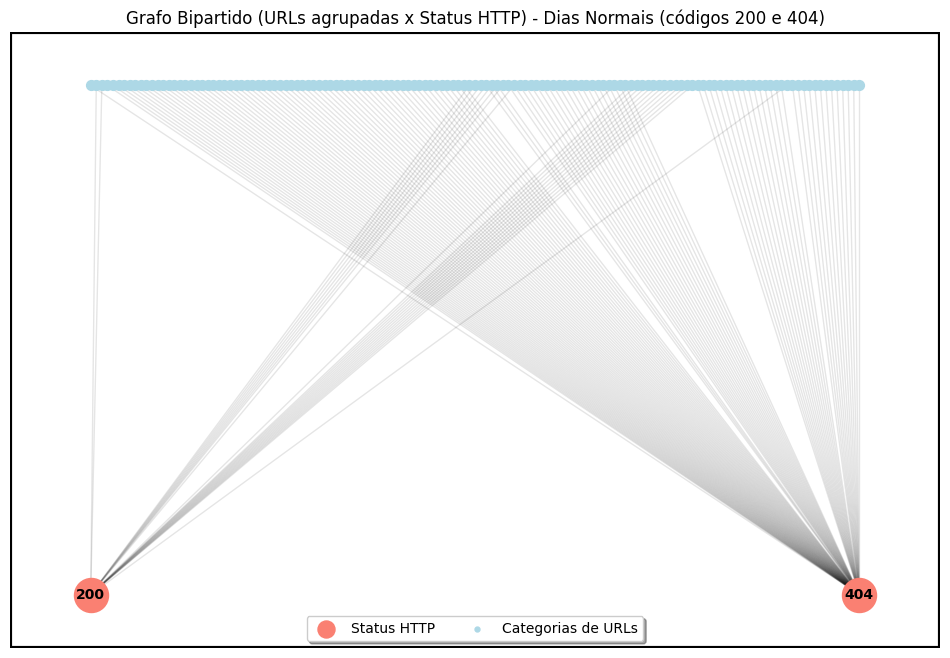

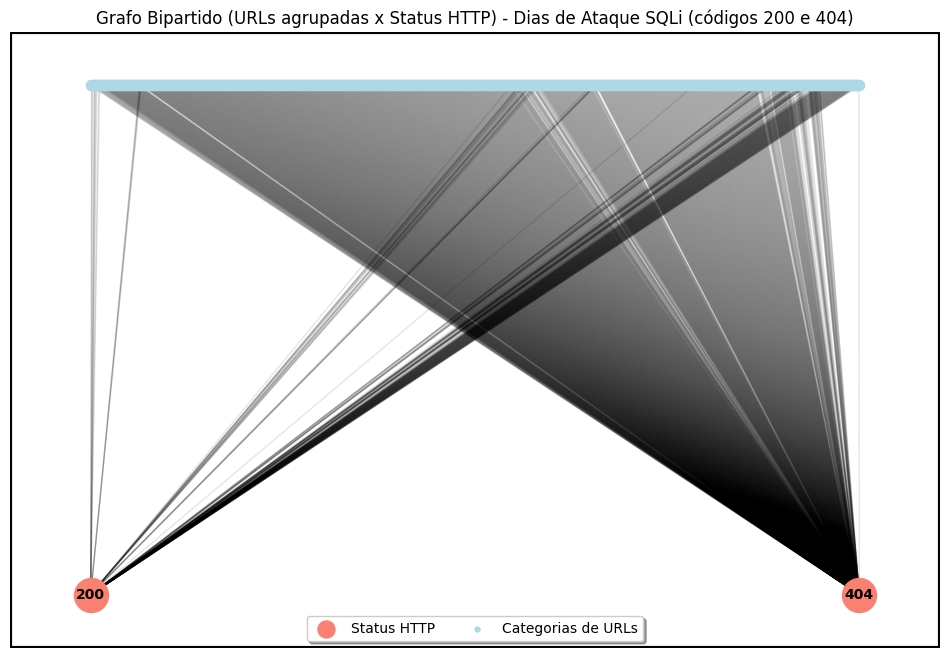

In [3]:
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Regex para parsing dos logs Apache (linha completa)
log_pattern = r'(?P<ip>\d+\.\d+\.\d+\.\d+) - - \[(?P<date>.*?)\] "(?P<method>\w+) (?P<url>\S+) HTTP/\d\.\d" (?P<status>\d{3}) (?P<size>\d+|-) "(?P<referrer>.*?)" "(?P<user_agent>.*?)"'

def carregar_logs_para_df(caminho_arquivo, status_para_filtrar=None):
    entries = []
    with open(caminho_arquivo, 'r', encoding='utf-8', errors='ignore') as file:
        for line in file:
            match = re.match(log_pattern, line)
            if match:
                entries.append(match.groupdict())
    df = pd.DataFrame(entries)
    df['status'] = df['status'].astype(int)

    if status_para_filtrar:
        # Filtra o DataFrame para incluir apenas os status desejados
        df = df[df['status'].isin(status_para_filtrar)]

    return df

def criar_grafo_bipartido_url_status(df):
    B = nx.Graph()
    for _, row in df.iterrows():
        url = row['url']
        status = str(row['status'])
        B.add_node(url, bipartite=0)
        B.add_node(status, bipartite=1)
        B.add_edge(url, status)
    return B

def agrupar_url_por_categoria(url):
    partes = url.strip('/').split('/')
    if len(partes) == 0:
        return '/'
    elif len(partes) == 1:
        return '/' + partes[0]
    else:
        return '/' + partes[0] + '/' + partes[1]  # Ex: /admin/login ou /agenda/imgs

def criar_grafo_bipartido_por_categoria(df):
    B = nx.Graph()
    for _, row in df.iterrows():
        categoria = agrupar_url_por_categoria(row['url'])
        status = str(row['status'])
        B.add_node(categoria, bipartite=0)
        B.add_node(status, bipartite=1)
        B.add_edge(categoria, status)
    return B


def desenhar_grafo_agrupado(B, titulo):
    # Separa os nós em seus respectivos conjuntos
    status_nos = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}
    url_nos = set(B) - status_nos # Este é o conjunto com bipartite=0

    # Altera o layout para horizontal, colocando os nós de 'status' (bipartite=1) na parte de cima
    # O parâmetro 'align' controla a orientação. 'vertical' é o padrão.
    # O 'set_a' define qual conjunto será posicionado no lado 'esquerdo' ou 'superior' (dependendo do alinhamento)
    pos = nx.bipartite_layout(B, nodes=list(status_nos), align='horizontal')

    plt.figure(figsize=(12, 8)) # Aumentei o tamanho da figura para melhor visualização horizontal

    url_nos = set(B) - status_nos
    # Nós de status (parte superior)
    nx.draw_networkx_nodes(B, pos, nodelist=list(status_nos), node_color='salmon', node_size=600, label='Status HTTP')
    nx.draw_networkx_labels(B, pos, labels={n: n for n in status_nos}, font_size=10, font_weight='bold')

    # Nós da URL (parte inferior)
    nx.draw_networkx_nodes(B, pos, nodelist=list(url_nos), node_color='lightblue', node_size=50, label='Categorias de URLs')
    # Para as URLs, geralmente não mostramos rótulos se houver muitas para evitar poluição visual.
    # Se você quiser mostrar, pode descomentar a linha abaixo, mas cuidado com a legibilidade.
    # nx.draw_networkx_labels(B, pos, labels={n: n for n in url_nos}, font_size=6)

    # Arestas
    nx.draw_networkx_edges(B, pos, alpha=0.1) # Diminuí a transparência das arestas para melhor visualização com muitas URLs

    plt.title(titulo)
    plt.axis('off')
    #plt.legend()
    plt.legend(loc='lower center', #bbox_to_anchor=(0.5, -0.15),
               ncol=2, # Número de colunas na legenda (útil se tiver muitos itens)
               fancybox=True, shadow=True, # Adiciona um estilo legal
               fontsize='medium', # Tamanho da fonte da legenda
               markerscale=0.5)
    
    # Dentro da função, logo após plt.gca():
    ax = plt.gca()
    # Rectangle: (x, y), largura, altura
    border = Rectangle(
        (0,0),1,1, transform=ax.transAxes,
        facecolor='none',
        edgecolor='black',
        linewidth=3,
        zorder=10
    )
    ax.add_patch(border)

    plt.show()


# Caminhos dos arquivos de log
#log_normal = 'access-sistemas-normal2.log'
log_normal = 'log3-junho-a3'
log_ataque = 'logs-invasao.log'

# --- CHAMADAS COM O NOVO FILTRO ---
# Carrega os dados e gera grafos, filtrando apenas status 200 e 404
df_normal_filtrado = carregar_logs_para_df(log_normal, status_para_filtrar=[200, 404])
df_ataque_filtrado = carregar_logs_para_df(log_ataque, status_para_filtrar=[200, 404])

grafo_normal_filtrado = criar_grafo_bipartido_por_categoria(df_normal_filtrado)
grafo_ataque_filtrado = criar_grafo_bipartido_por_categoria(df_ataque_filtrado)

# Visualizações
desenhar_grafo_agrupado(grafo_normal_filtrado, "Grafo Bipartido (URLs agrupadas x Status HTTP) - Dias Normais (códigos 200 e 404)")
desenhar_grafo_agrupado(grafo_ataque_filtrado, "Grafo Bipartido (URLs agrupadas x Status HTTP) - Dias de Ataque SQLi (códigos 200 e 404)")



In [4]:
print("Grafo dias normais")
relatorio_metrico_bipartido(grafo_normal_filtrado)
print("\nGrafo dia ataque")
relatorio_metrico_bipartido(grafo_ataque_filtrado)


Grafo dias normais
Número de nós: 141
Número de arestas: 144
Número de componentes conectados: 1
Grau médio: 2.04
Grau médio dos nós tipo 0 (URLs ou categorias): 1.04
Grau médio dos nós tipo 1 (Status HTTP): 72.00

Grafo dia ataque
Número de nós: 1909
Número de arestas: 1912
Número de componentes conectados: 1
Grau médio: 2.00
Grau médio dos nós tipo 0 (URLs ou categorias): 1.00
Grau médio dos nós tipo 1 (Status HTTP): 956.00
